In [1]:
import nltk, re, os
import numpy as np
from matplotlib import pyplot as plt
from nltk.tokenize import texttiling, sent_tokenize, word_tokenize
from nltk.corpus import brown

### TextTiling

#### Test123

In [3]:
test_text = brown.raw()[:1000]
tt_en = texttiling.TextTilingTokenizer(demo_mode=False)
# tt_en.tokenize(test_text)

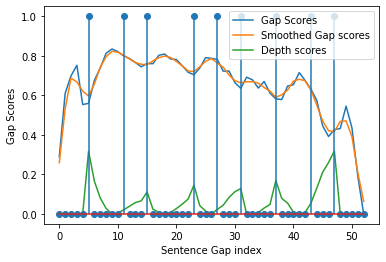

In [2]:
texttiling.demo()

#### Grab text

Gebruik data-analyse om parameters (hoeveelheid woorden in zin voor W; hoeveelheid zinnen in paragraaf voor K; etc.) op te baseren.

In [17]:
def clean_text(text):
    """
    Removes lines starting with "===" from string.
    Replace \n with \n\n (for nltk).
    """
    t = re.sub(r'^(?:(<doc)|(<\/doc)).*\n', '', text, flags=re.MULTILINE)
    t = re.sub(r'^===.*\n', '', t, flags=re.MULTILINE)
    return re.sub('\n','\n\n', t)

def get_truth(text: str):
    t = re.sub(r'^(?:(<doc)|(<\/doc)).*\n', '', text, flags=re.MULTILINE)
    t = re.sub(r'^===.*\n', '===', t, flags=re.MULTILINE)
    nopunct_t = "".join(
            c for c in t.lower() if re.match(r"[a-z\-' \n\t]", c)
        )
    # t_sep = sent_tokenize(t)
    t_sep = re.findall(r"[\w\-']+", nopunct_t)
    return [1 if s.startswith('===') else 0 for s in t_sep]

class texttilingX(texttiling.TextTilingTokenizer):
    def __init__(self, text: str, **kwargs):
        super().__init__(**kwargs)
        self.text = re.sub(r'^(?:(<doc)|(<\/doc)).*\n', '', text, flags=re.MULTILINE) # Not fully cleaned text
        # TODO: gebruik num2words om nummers naar text te veranderen: https://pypi.org/project/num2words/
        # TODO: gebruik r"[\wÀ-ÖØ-öø-ÿ\-\' \n\t]" voor regex matching OVERAL!

    def tokenize(self):
        t = re.sub(r'^===.*\n', '', self.text, flags=re.MULTILINE) # Remove headers
        return super().tokenize(text=re.sub('\n', '\n\n', t))

    def word_tokenize(self):
        """
        Returns all the words in the text.
        """
        t = re.sub(r'^===.*\n', '', self.text, flags=re.MULTILINE) # Remove headers
        nopunct_t = "".join(c for c in t.lower() if re.match(r"[a-z\-' \n\t]", c))
        return re.findall(r"[\w\-']+", nopunct_t)

    def get_truth(self):
        t = re.sub(r'^===.*\n', '===', self.text, flags=re.MULTILINE) # Remove headers, but add '===' at the start of section
        t_sep = re.findall(r"(?:={3})?[a-z\-']+", t.lower()) # Grab all words (inc. starting with '==='); ignore punctuation etc.
        return [1 if s.startswith('===') else 0 for s in t_sep]

    def plot(self, s, ss, d, b):
        """
        The scores represent the score of token-sequence GAPS.
        So a boundary score of 1 at i=0 means that a boundary occurs between segments 0 and 1.
        To plot this out per words, we translate the token-sequence gaps to the beginning of a new sequence by shifting everything right and adding a 0 at the start.
        Additionally adds a 0 at the end to signify the very last word.
        """
        # Shift to the right + add ending 0
        s_adj = [0] + s + [0]
        ss_adj = [0] + ss + [0]
        d_adj = [0] + d + [0]
        b_adj = [1] + b + [0] # Start of text is always a boundary, kinda

        word_n = len(self.word_tokenize())
        word_indices = np.append(np.arange(len(s_adj[:-1])) * self.w, word_n)

        ground_truth = self.get_truth()
        fig, ax = plt.subplots(figsize=(20,5),)
        ax.set_xlabel("Word index")
        ax.set_ylabel("Scores")
        # ax.set_ylim(-0.1, 1.1)
        ax.set_ylim(0, 1)

        labels = []
        labels_loc = []
        cur_loc = 0
        # Get start locations of each sentence
        t = re.sub(r'^===.*\n', '', self.text, flags=re.MULTILINE)
        for s in sent_tokenize(t):
            nopunct_s = re.findall(r"[A-Za-z\-']+", s)
            labels.append(f'{cur_loc}\n{nopunct_s[0][:3]}...')
            labels_loc.append(cur_loc)
            cur_loc += len(nopunct_s)

        ax.set_xticks(labels_loc, labels)
        ax.plot(word_indices, s_adj, label="Gap Scores", color='b')
        ax.plot(word_indices, ss_adj, label="Smoothed Gap scores", color='g')
        ax.plot(word_indices, d_adj, label="Depth scores", color='y')
        ax.vlines(range(len(ground_truth)), ymin=0, ymax=ground_truth, color='r', label="Ground Truth")
        _, _, baseline = ax.stem(word_indices, b_adj, linefmt='--', markerfmt=' ', label="Predicted boundaries")
        plt.setp(baseline, color='k', alpha=0.5)
        ax.legend()
        fig.show()

In [3]:
with open('../NLWiki/AA/wiki_02', 'r') as file:
    nl_text = file.read()

In [18]:
tt = texttilingX(text=nl_text, demo_mode=True, stopwords=nltk.corpus.stopwords.words('dutch'))
res = tt.tokenize()

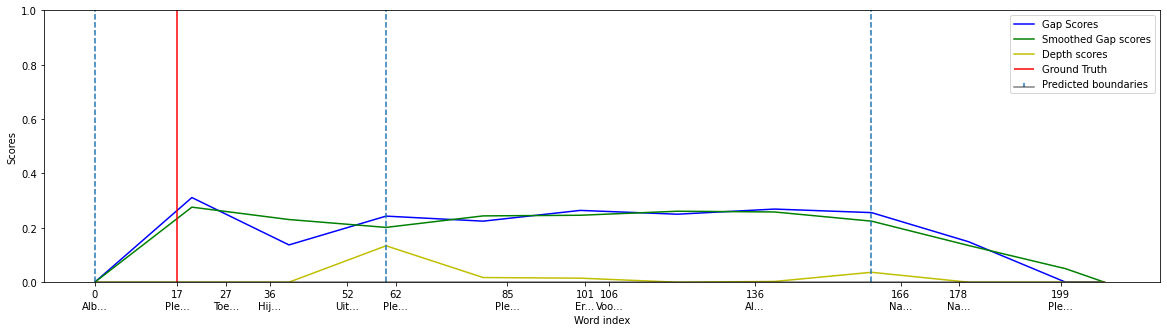

In [19]:
tt.plot(*res)